# **Part A**
Count / Frequency based Naive Bayes Classifier

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Students must implement the following steps:
# 1. Complete the fit method in NaiveBayesClassifier (4 TODOs for log prior and log likelihood calculation).
# 2. Complete the predict method in NaiveBayesClassifier (2 TODOs for log probability accumulation and final argmax).
# 3. Complete the data loading calls in Section 2.
# 4. Initialize CountVectorizer with proper parameters in Section 3a.
# 5. Complete the feature transformation (fit_transform and transform) in Section 3a.
# 6. Initialize and fit the custom nb_model in Section 3b.
# 7. Use the fitted nb_model to generate predictions in Section 4.
# =======================================================


# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # // TODO: Calculate the log prior and store it in self.class_priors[c]
            # Calculate Class Prior P(C): log(P(C))
            # P(C) = (Number of samples in class c) / (Total number of samples)
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing (additive smoothing, alpha=1.0 default):
            # P(w_i | C) = (count(w_i, C) + alpha) / (total_words_in_C + alpha * vocab_size)

            # // TODO: Calculate the numerator (with Laplace smoothing)
            numerator = feature_sum + self.alpha

            # // TODO: Calculate the denominator (with Laplace smoothing)
            denominator = total_mass + (self.alpha * self.vocabulary_size)

            # // TODO: Calculate the log likelihood (log(numerator / denominator))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}

            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # // TODO: Complete the log probability calculation for the likelihood term
                # Add log likelihoods contribution (Log-Sum Trick):
                # log_prob += sum(count(w_i) * log(P(w_i|C)))
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])

                scores[c] = log_prob

            # // TODO: Find the key (class label) with the maximum score
            predicted_class = max(scores, key=scores.get)

            y_pred.append(predicted_class)

        # // TODO: Return the final predictions array
        return np.array(y_pred)


In [ ]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = os.path.dirname(os.path.abspath('__file__'))
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'Dataset', 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'Dataset', 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'Dataset', 'test.txt'))


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [6]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # // TODO: Set appropriate ngram_range
        ngram_range=(1, 2),  # using unigrams and bigrams for richer features
        # // TODO: Set appropriate min_df
        min_df=2  # ignore very rare terms appearing in less than 2 documents
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # // TODO: Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # // TODO: Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)

    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # // TODO: Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # // TODO: Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")


Fitting Count Vectorizer and transforming training data...
Vocabulary size: 301234
Transforming test data...
Vocabulary size: 301234
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [7]:
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# Train if not already trained
if 'nb_model' not in locals():
    nb_model = NaiveBayesClassifier(alpha=1.0)
    nb_model.fit(X_train_counts, y_train)

# Predict on test set
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    target_names = np.unique(y_test)
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7571
Accuracy: 0.7571
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.56      0.57      3621
 CONCLUSIONS       0.63      0.69      0.66      4571
     METHODS       0.81      0.89      0.85      9897
   OBJECTIVE       0.60      0.43      0.50      2333
     RESULTS       0.87      0.80      0.84      9713

    accuracy                           0.76     30135
   macro avg       0.70      0.68      0.68     30135
weighted avg       0.76      0.76      0.75     30135

Macro-averaged F1 score: 0.6825
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.56      0.57      3621
 CONCLUSIONS       0.63      0.69      0.66      4571
     METHODS       0.81      0.89      0.85      9897
   OBJECTIVE       0.60      0.43      0.50      2333
     RESULTS       0.87      0.80      0.84      9713

    accuracy                           0.76     30135
   

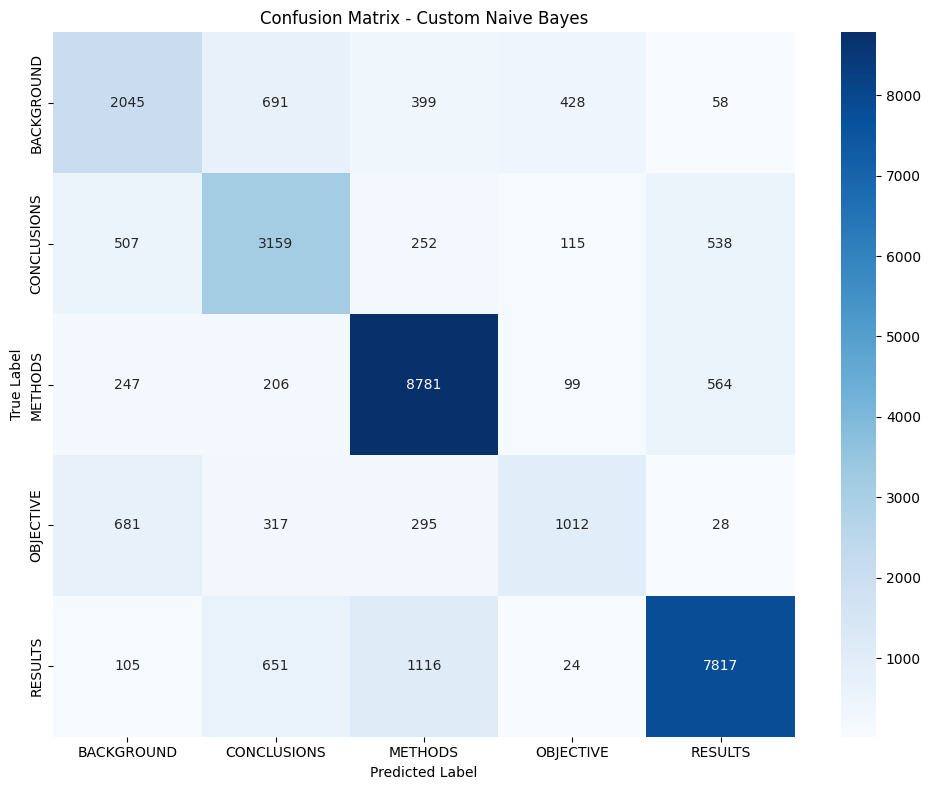

In [8]:
# Confusion Matrix on test set
    # // TODO: Use the confusion_matrix, matplotlib, and seaborn libraries to generate
    # a visual confusion matrix (heatmap) for the predicted results.
    # if y_test_pred is not None:
    #     cm = confusion_matrix(...)
    #     plt.figure(...)
    #     sns.heatmap(...)
    #     plt.show()

if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix - Custom Naive Bayes')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# **Part B**
TF-IDF score based Classifier

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Implement the following steps:
# 1. Define the initial `pipeline` combining TfidfVectorizer and MultinomialNB with default parameters.
# 2. Train the initial pipeline on the training data (X_train, y_train).
# 3. Predict and evaluate the performance of the initial model on the test data (X_test, y_test).
# 4. Define the `param_grid` for hyperparameter tuning.
# 5. Initialize `GridSearchCV` using the pipeline, parameter grid, and appropriate cross-validation settings.
# 6. Fit the Grid Search object using the development data (X_dev, y_dev).
# 7. Print the `best_params_` and `best_score_` found by the grid search.
# =======================================================


# // TODO: Define a Pipeline named 'pipeline' using TfidfVectorizer and MultinomialNB.
# Use standard initial parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# // TODO: Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")


# Predict and evaluate on test set
# // TODO: Predict y_test_pred and calculate metrics
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)
if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")

# Hyperparameter Tuning using GridSearchCV

# // TODO: Define the parameter grid 'param_grid' to tune both TF-IDF and NB parameters.
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]
}

# // TODO: Initialize GridSearchCV using the pipeline and param_grid.
# Ensure cv=3 and scoring='f1_macro' are used.
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro')

print("\nStarting Hyperparameter Tuning on Development Set...")
# // TODO: Fit the GridSearchCV object using the development data.
grid.fit(X_dev, y_dev)
print("Grid search complete.")

if grid is not None and hasattr(grid, 'best_params_'):
    print(f"\nBest Parameters: {grid.best_params_}")
    print(f"Best Cross-Validation F1 Score: {grid.best_score_:.4f}")
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===

=== Test Set Evaluation (Initial Sklearn Model) ===
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7266
Accuracy: 0.7266
              precision    recall  f1-score   support

  BACKGROUND       0.64      0.43      0.51      3621
 CONCLUSIONS       0.62      0.61      0.62      4571
     METHODS       0.72      0.90      0.80      9897
   OBJECTIVE       0.73      0.10      0.18      2333
     RESULTS       0.80      0.87      0.83      9713

    accuracy                           0.73     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.72      0.73      0.70     30135

Macro-averaged F1 score: 0.5877

Starting Hyperparameter Tuning on Development Set...
              precision    recall  f1-score   support

  BACKGROUND       0.64      0.43      0.51  

# **Part C**
Bayes Optimal Classifier

Part C Draft

Using dynamic sample size: 10913
THE SRN: PES2UG23CS913
Actual sampled training set size used: 10913

Defining improved base models...

Training all base models on full sampled data...
Training NaiveBayes...
Training LogisticReg1...
Training LogisticReg1...


c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Training LinearSVM...
Training RandomForest...
Training RandomForest...
Training LogisticReg2...
Training LogisticReg2...


c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


All base models trained.

Calculating Posterior Weights using improved method...
Evaluating NaiveBayes on validation set...
NaiveBayes - Validation Accuracy: 0.6460, Avg Log-Likelihood: -0.9085
Evaluating LogisticReg1 on validation set...
NaiveBayes - Validation Accuracy: 0.6460, Avg Log-Likelihood: -0.9085
Evaluating LogisticReg1 on validation set...


c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


LogisticReg1 - Validation Accuracy: 0.6808, Avg Log-Likelihood: -0.9241
Evaluating LinearSVM on validation set...
LinearSVM - Validation Accuracy: 0.7017, Avg Log-Likelihood: -0.8336
Evaluating RandomForest on validation set...
LinearSVM - Validation Accuracy: 0.7017, Avg Log-Likelihood: -0.8336
Evaluating RandomForest on validation set...
RandomForest - Validation Accuracy: 0.5350, Avg Log-Likelihood: -1.2915
Evaluating LogisticReg2 on validation set...
RandomForest - Validation Accuracy: 0.5350, Avg Log-Likelihood: -1.2915
Evaluating LogisticReg2 on validation set...


c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticReg2 - Validation Accuracy: 0.6966, Avg Log-Likelihood: -0.8368

Final Posterior Weights: [0.2009679182397065, 0.20748135475828, 0.21777524714310037, 0.15731856170174682, 0.21645691815716628]
Model Accuracies: [0.6460241846830341, 0.68083547086845, 0.7017222425796995, 0.5349945034811286, 0.6965921582997435]

Refitting all models on full sampled training data...
Refitting NaiveBayes...
Refitting LogisticReg1...
Refitting LogisticReg1...


c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Refitting LinearSVM...
Refitting RandomForest...
Refitting RandomForest...
Refitting LogisticReg2...
Refitting LogisticReg2...


c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


All models refitted.

Fitting the VotingClassifier (BOC approximation)...


c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\nanda\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its defaul

Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7233
Macro-averaged F1 Score: 0.6284

Classification Report:

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7233
Macro-averaged F1 Score: 0.6284

Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.59      0.38      0.47      3621
 CONCLUSIONS       0.62      0.58      0.60      4571
     METHODS       0.73      0.90      0.80      9897
   OBJECTIVE       0.65      0.35      0.46      2333
     RESULTS       0.80      0.83      0.81      9713

    accuracy                           0.72     30135
   macro avg       0.68      0.61      0.63     30135
weighted avg       0.71      0.72      0.71     30135

              precision    recall  f1-score   support

  BACKGROUND       0.59      0.38      0.47      3621
 CONCLUSIONS       0.62      0.58      0.60      4571
     METHODS       0.73  

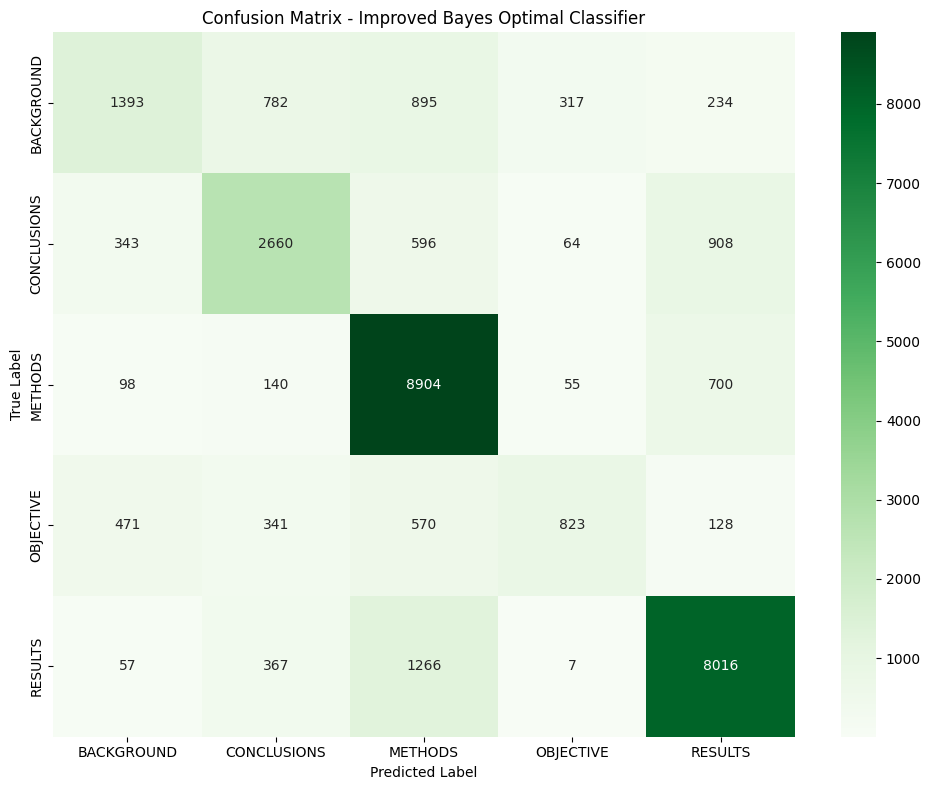


=== Individual Model Performances on Test Set ===
NaiveBayes: Accuracy=0.6867, F1=0.5492
NaiveBayes: Accuracy=0.6867, F1=0.5492
LogisticReg1: Accuracy=0.7138, F1=0.6171
LogisticReg1: Accuracy=0.7138, F1=0.6171
LinearSVM: Accuracy=0.7309, F1=0.6516
LinearSVM: Accuracy=0.7309, F1=0.6516
RandomForest: Accuracy=0.5439, F1=0.2911
RandomForest: Accuracy=0.5439, F1=0.2911
LogisticReg2: Accuracy=0.7291, F1=0.6458
LogisticReg2: Accuracy=0.7291, F1=0.6458


In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split

# =======================================================
# IMPROVED BOC IMPLEMENTATION
# =======================================================

# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000

# Prompt the user for their full SRN
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}")
print(f"THE SRN: {FULL_SRN}")

# Placeholder initialization
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

# IMPROVED: Better TF-IDF parameters for better feature representation
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 2),  # Include bigrams for better context
    'min_df': 3,  # Slightly higher to reduce noise
    'max_df': 0.8,  # Remove very common words
    'sublinear_tf': True  # Use log scaling for term frequency
}

# IMPROVED: Define better-tuned diverse hypotheses
print("\nDefining improved base models...")

# H1: Multinomial Naive Bayes with optimized alpha
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=0.5))  # Optimized alpha
])

# H2: Logistic Regression with L2 regularization
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(
        solver='liblinear', 
        multi_class='ovr', 
        C=1.0,  # Regularization strength
        max_iter=1000, 
        random_state=42
    ))
])

# H3: Linear SVM (often better for text than Random Forest)
h3_svm = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        LinearSVC(C=0.5, max_iter=2000, random_state=42),
        cv=3
    ))
])

# H4: Random Forest with better parameters
h4_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', RandomForestClassifier(
        n_estimators=100,  # More trees
        max_depth=15,  # Deeper trees
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=1
    ))
])

# H5: Logistic Regression with different regularization
h5_lr2 = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(
        solver='saga',
        multi_class='multinomial',
        C=2.0,  # Different regularization
        max_iter=1000,
        random_state=42
    ))
])

hypotheses = [h1_nb, h2_lr, h3_svm, h4_rf, h5_lr2]
hypothesis_names = ['NaiveBayes', 'LogisticReg1', 'LinearSVM', 'RandomForest', 'LogisticReg2']

# Train all base models on full sampled data first
print("\nTraining all base models on full sampled data...")
for i, (name, model) in enumerate(zip(hypothesis_names, hypotheses)):
    print(f"Training {name}...")
    model.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")

# IMPROVED: Calculate posterior weights using cross-validation approach
print("\nCalculating Posterior Weights using improved method...")

# Split for validation
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled,
    test_size=0.25,  # Larger validation set
    random_state=42,
    stratify=y_train_sampled
)

log_likelihoods = []
model_accuracies = []

for i, (name, model) in enumerate(zip(hypothesis_names, hypotheses)):
    print(f"Evaluating {name} on validation set...")
    
    # Create and train a fresh model
    if name == 'NaiveBayes':
        temp_model = Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('clf', MultinomialNB(alpha=0.5))
        ])
    elif name == 'LogisticReg1':
        temp_model = Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('clf', LogisticRegression(
                solver='liblinear', multi_class='ovr', C=1.0,
                max_iter=1000, random_state=42
            ))
        ])
    elif name == 'LinearSVM':
        temp_model = Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('clf', CalibratedClassifierCV(
                LinearSVC(C=0.5, max_iter=2000, random_state=42), cv=3
            ))
        ])
    elif name == 'RandomForest':
        temp_model = Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('clf', RandomForestClassifier(
                n_estimators=100, max_depth=15,
                min_samples_split=5, min_samples_leaf=2,
                random_state=42, n_jobs=1
            ))
        ])
    else:  # LogisticReg2
        temp_model = Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('clf', LogisticRegression(
                solver='saga', multi_class='multinomial', C=2.0,
                max_iter=1000, random_state=42
            ))
        ])
    
    temp_model.fit(X_train_sub, y_train_sub)
    
    # Get validation accuracy
    y_val_pred = temp_model.predict(X_val_sub)
    val_accuracy = accuracy_score(y_val_sub, y_val_pred)
    model_accuracies.append(val_accuracy)
    
    # Get predicted probabilities
    y_val_proba = temp_model.predict_proba(X_val_sub)
    
    # Calculate log-likelihood
    true_class_indices = np.array([temp_model.classes_.tolist().index(label) for label in y_val_sub])
    log_probs = np.log(np.clip(y_val_proba[np.arange(len(y_val_sub)), true_class_indices], 1e-10, 1.0))
    avg_log_likelihood = np.mean(log_probs)
    
    log_likelihoods.append(avg_log_likelihood)
    print(f"{name} - Validation Accuracy: {val_accuracy:.4f}, Avg Log-Likelihood: {avg_log_likelihood:.4f}")

# IMPROVED: Use both accuracy and log-likelihood for weights
# Normalize accuracies and log-likelihoods separately, then combine
normalized_accuracies = np.array(model_accuracies) / np.sum(model_accuracies)

# Convert log-likelihoods to probabilities
log_likelihoods = np.array(log_likelihoods)
likelihoods = np.exp(log_likelihoods - np.max(log_likelihoods))
normalized_likelihoods = likelihoods / np.sum(likelihoods)

# Combine both metrics (70% accuracy, 30% likelihood)
posterior_weights = 0.7 * normalized_accuracies + 0.3 * normalized_likelihoods
posterior_weights = posterior_weights / np.sum(posterior_weights)
posterior_weights = posterior_weights.tolist()

print(f"\nFinal Posterior Weights: {posterior_weights}")
print(f"Model Accuracies: {model_accuracies}")

# Refit all models on full sampled data
print("\nRefitting all models on full sampled training data...")
for i, (name, model) in enumerate(zip(hypothesis_names, hypotheses)):
    print(f"Refitting {name}...")
    model.fit(X_train_sampled, y_train_sampled)
print("All models refitted.")

# Create and fit the Voting Classifier
estimators = list(zip(hypothesis_names, hypotheses))

boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")

# Make predictions on test set
print("\nPredicting on test set...")
y_pred = boc_soft_voter.predict(X_test)

# Final Evaluation
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None:
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro-averaged F1 Score: {f1_macro:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=target_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix - Improved Bayes Optimal Classifier')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Show individual model performances on test set
    print("\n=== Individual Model Performances on Test Set ===")
    for name, model in zip(hypothesis_names, hypotheses):
        y_pred_individual = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred_individual)
        f1 = f1_score(y_test, y_pred_individual, average='macro')
        print(f"{name}: Accuracy={acc:.4f}, F1={f1:.4f}")
else:
    print("Evaluation skipped: Predictions not generated.")